# Amazon Fine Food Reviews Analysis

In [1]:

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [2]:
filtered_data.shape #looking at the number of attributes and size of the data

(525814, 10)

In [3]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:

s_data=filtered_data[0:1000]
s_data=s_data[s_data.HelpfulnessNumerator<=s_data.HelpfulnessDenominator]

s_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,positive,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,positive,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,positive,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,positive,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [5]:
s_data.shape

(1000, 10)

In [6]:
s_data['Score'].value_counts()

positive    843
negative    157
Name: Score, dtype: int64

# Bag of words

In [7]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
f_counts = count_vect.fit_transform(s_data['Text'].values)


In [8]:
type(f_counts)

scipy.sparse.csr.csr_matrix

In [9]:
f_counts.get_shape()

(1000, 6033)

In [15]:
#T-SVD
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

review = s_data['Score']

model = TruncatedSVD(n_components=1000)
Tsvd_data = model.fit_transform(f_counts)

percentage_var_explained = model.explained_variance_ / np.sum(model.explained_variance_);

cum_var_explained=np.cumsum(percentage_var_explained)

plt.figure(1 , figsize=(6,4))

plt.clf()
plt.plot(cum_var_explained,linewidth = 2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')

Text(0,0.5,'Cumulative_explained_variance')

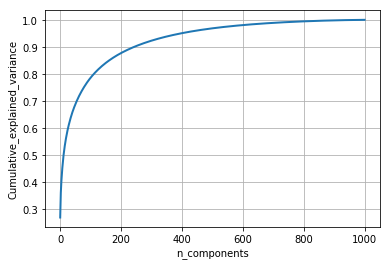

In [16]:
plt.show()

Observation :
1. We can observe in above graph that is 100% variance is explained and the Graph shape is increasing point to point 

# T-SNE for BOW

In [30]:
mod = TruncatedSVD(n_components = 400)
tsne_data = model.fit_transform(f_counts)

model_tsne = TSNE(n_components = 2, random_state=0, perplexity=50)
tsne_data = model_tsne.fit_transform(Tsvd_data)

tsne_data = np.vstack((tsne_data.T,review)).T
tsne_df = pd.DataFrame(data=tsne_data,columns=('d1','d2','review'))

tsne_bow = sns.FacetGrid(tsne_df,hue='review',size=6).map(plt.scatter,'d1','d2').add_legend()

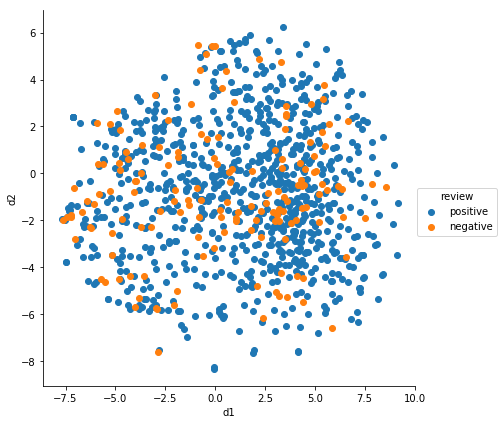

In [31]:
tsne_bow
plt.show()

Observations :
1. When we are using Bag of words, we can observe that positive and negative review are Overlaping

# Bi-Grams

In [34]:
count_vect1=CountVectorizer(ngram_range=(1,2))
final_count1=count_vect1.fit_transform(s_data['Text'].values)

# T-SNE Vizulization for Above Bi-Gram

In [51]:
model1=TruncatedSVD(n_components = 2)
tsvd_data1=model1.fit_transform(final_count1)

model_tsne1=TSNE(n_components=2,random_state=0,perplexity=50)
tsne_data1 = model_tsne1.fit_transform(tsvd_data1)

tsne_data1=np.vstack((tsne_data1.T,review)).T
tsne_df1=pd.DataFrame(data=tsne_data1,columns=('d1','d2','review'))


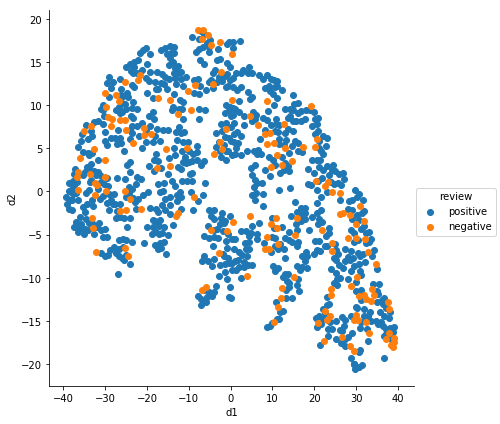

In [53]:
sns.FacetGrid(tsne_df1,hue='review',size=6).map(plt.scatter,'d1','d2').add_legend()
plt.show()

Observations :
    1.When we are using Bi-grams, we can observe that positive and negative review are Overlaping

# TF-IDF

In [54]:
tf_idf_vect=TfidfVectorizer(ngram_range=(1,2))
tf_idf=tf_idf_vect.fit_transform(s_data['Text'].values)

In [55]:
print(tf_idf.shape)

(1000, 43815)


# TF-IDF in T-sne Vizulization

In [60]:
model2=TruncatedSVD(n_components=2)
tsvd_data2=model2.fit_transform(tf_idf)

model_tsne2=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
tsne_data2=model_tsne2.fit_transform(tsvd_data2)

tsne_data2=np.vstack((tsne_data2.T,review)).T
tsne_df2=pd.DataFrame(data=tsne_data2,columns=('d1','d2','review'))


sns.FacetGrid(tsne_df2,hue='review',size=6).map(plt.scatter,'d1','d2').add_legend()

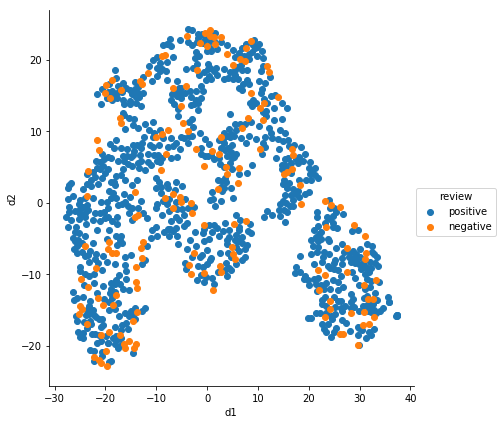

In [62]:
plt.show()

Observation :
1. When we are using TF-IDF, we can observe that positive and negative review are Overlaping

In [63]:
import re
import string
def cleanhtml(sentence): #function to clean the word of any html-tags
 cleanr = re.compile('<.*?>')
 cleantext = re.sub(cleanr, ' ', sentence)
 return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characte
 cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
 cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
 return cleaned

# Removing the Punctuations and HTML Tags too

# Word 2 Vec

In [69]:
i=0
list_of_sent=[]
for sent in s_data['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence)

In [74]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50,workers=4)

In [75]:
w2v_model.wv.most_similar('tasty')

[('flavor', 0.9997333884239197),
 ('from', 0.9997327923774719),
 ('made', 0.9997131824493408),
 ('wonderful', 0.9997129440307617),
 ('almost', 0.9997113347053528),
 ('perfect', 0.999708890914917),
 ('their', 0.9997059106826782),
 ('who', 0.9997023344039917),
 ('other', 0.999700129032135),
 ('she', 0.999698281288147)]

In [76]:
words = list(w2v_model.wv.vocab)
print(len(words))


1472


In [77]:
w2v=np.asmatrix(w2v_model)

# Avg Word 2 Vec

In [78]:
sent_vectors = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
type(sent_vectors)

1000
50


list

# T-SNE Visulization for Avg Word 2 Vec

In [82]:
model3=TruncatedSVD(n_components=2)
tsvd_data3=model3.fit_transform(sent_vectors)

model_tsne3=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
tsne_data3=model_tsne3.fit_transform(tsvd_data3)

tsne_data3=np.vstack((tsne_data3.T,review)).T
tsne_df3=pd.DataFrame(data=tsne_data3,columns=('d1','d2','review'))

sns.FacetGrid(tsne_df3,hue='review',size=6).map(plt.scatter,'d1','d2').add_legend()

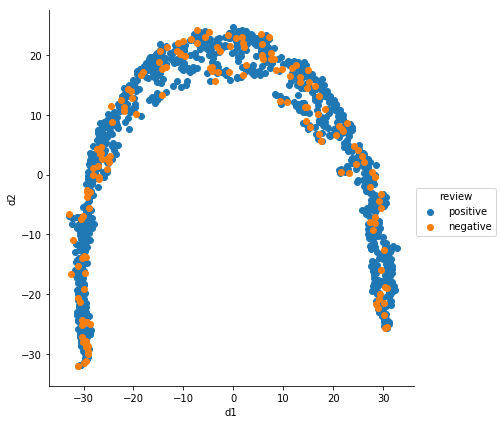

In [83]:
plt.show()

Observation :
1.When we are use Avg Word 2 vec, we can observe that positive and negative review are Overlaping